In [9]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

In [10]:

# import the data and split into train, test
df = pd.read_csv('kerastestdata.csv')

df['competitor'] = pd.Categorical(df['competitor'])

df['competitor'] = df['competitor'].cat.codes

X = df.drop('competitor', 1)
Y = to_categorical(df['competitor'])

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y, shuffle= True)


In [11]:
# keras model

model = Sequential()
model.add(Dense(128, input_shape=(2, ), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))


# output layer
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

earlystopping_callback = EarlyStopping(monitor='val_acc', 
                                patience=5)

# we can create another keras callback ModelCheckpoint and save the best model in a same way like EarlyStopping
history = model.fit(xtrain, ytrain, 
          epochs=1000, validation_data=(xtest, ytest),
          callbacks=[earlystopping_callback])



Train on 600 samples, validate on 200 samples
Epoch 1/1000
600/600 [==============================] - 1s 2ms/step - loss: 1.3637 - acc: 0.2700 - val_loss: 1.3463 - val_acc: 0.2450
Epoch 2/1000
600/600 [==============================] - 0s 91us/step - loss: 1.3172 - acc: 0.3033 - val_loss: 1.2980 - val_acc: 0.3100
Epoch 3/1000
600/600 [==============================] - 0s 57us/step - loss: 1.2566 - acc: 0.3850 - val_loss: 1.2263 - val_acc: 0.4900
Epoch 4/1000
600/600 [==============================] - 0s 40us/step - loss: 1.1710 - acc: 0.5383 - val_loss: 1.1283 - val_acc: 0.5200
Epoch 5/1000
600/600 [==============================] - 0s 38us/step - loss: 1.0683 - acc: 0.5450 - val_loss: 1.0236 - val_acc: 0.5350
Epoch 6/1000
600/600 [==============================] - 0s 38us/step - loss: 0.9703 - acc: 0.5633 - val_loss: 0.9359 - val_acc: 0.5250
Epoch 7/1000
600/600 [==============================] - 0s 40us/step - loss: 0.9038 - acc: 0.5983 - val_loss: 0.8786 - val_acc: 0.5850
Epoch 8/10

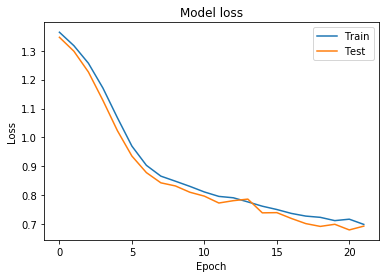

In [12]:
# lets plot the learning curve of this model
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


Early stopping is basically stopping the training once your loss starts to increase (or in other words validation accuracy 
starts to decrease). Eventhough, 1000 epocs was used initially in the model,
the early stopping callback has stopped model way before that, thus preventing model
from being overfitting. 

In next exercise, I will be doing some strategy to increase model performance and
do some hyperparameters tunning


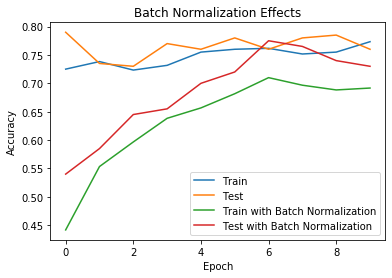

In [13]:
# model with batchnormalization

b_model = Sequential()
b_model.add(Dense(128, input_shape=(2,), activation='relu', kernel_initializer='normal'))
b_model.add(BatchNormalization())
b_model.add(Dense(64, activation='relu', kernel_initializer='normal'))
b_model.add(BatchNormalization())
b_model.add(Dense(32, activation='relu', kernel_initializer='normal'))
b_model.add(BatchNormalization())


b_model.add(Dense(4, activation='softmax', kernel_initializer='normal'))


# Compile your model with adam
b_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# lets compare previous model and this batch model
history1 = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=10, verbose=0)

# Train the batch normalized model you recently built, store its history
history2 = b_model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=10, verbose=0)

# Call compare_acc_histories passing in both model histories
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title("Batch Normalization Effects")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test', 'Train with Batch Normalization', 'Test with Batch Normalization'], loc='best')
plt.show()


Our model wasnt much difference in Batch Normalization compared to without batch normalisation.

In this final steps of this exercise, I am going to try to use some hyperparameters tunning.


In [14]:
# define a model for a given activation and learning rate

def create_model(learningrate = 0.001, activation = 'relu'):
    opt = Adam(lr= learningrate)
    
    model = Sequential()
    model.add(Dense(128, input_shape=(2, ), activation= activation))
    model.add((Dense(64, activation= activation)))
    model.add(Dense(32, activation = activation))
    
    model.add((Dense(4, activation = 'softmax')))
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return  model


model = KerasClassifier(build_fn=create_model)

params = {'activation':['relu', 'tanh'], 
          'epochs':[50, 100]}

'''
This random-search can takes quite a lot of time. However, at the end, this random search
will be able to give the best params for our model. 
'''

random_search = RandomizedSearchCV(model, param_distributions=params, cv=KFold(3))

random_search.fit(X, Y)

print(random_search.best_params_)

'\nThis random-search can takes quite a lot of time. However, at the end, this random search\nwill be able to give the best params for our model. \n'